**Women's Clothing E-Commerce Reviews**

**EDA(non text)**

1.1 Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora import Dictionary
from gensim.models import LdaModel


In [2]:
df = pd.read_csv('data/WomensClothingE-CommerceReviews.csv')

1.2 Basic info

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


1.3 Missing Value and dupliacte

C:\Users\Alvis\AppData\Local\Temp\ipykernel_5776\332695394.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


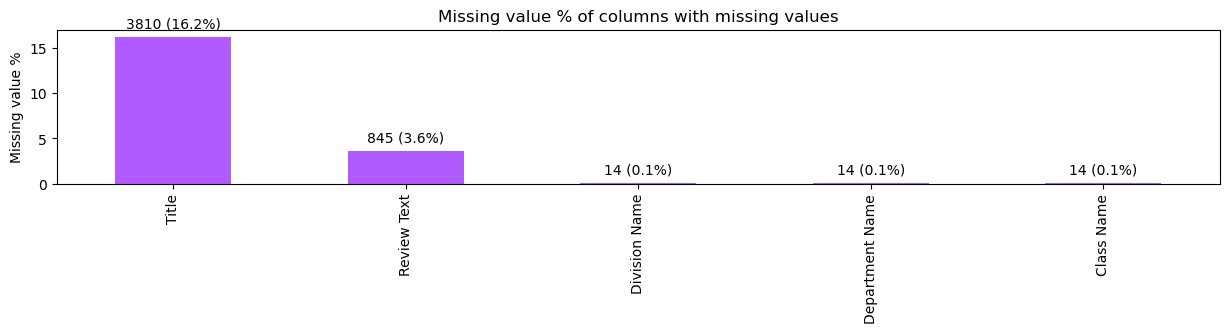

In [6]:
# missing value % and counts
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='#B15BFF')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value %")
plt.title("Missing value % of columns with missing values")
plt.show()

In [7]:
# Delete rows with missing values in "Review Text"
print("Rows before deleting missing values in review text: ", df.shape[0])
df.dropna(subset=['Review Text'], inplace=True)
print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


In [8]:
# Fill in missing values with blank for other object type columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')
                    
df.isna().sum().sum()

0

In [9]:
# Drop "Unamed: 0" column
df.drop("Unnamed: 0", axis=1, inplace=True)

In [10]:
# check duplicates
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


In [11]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


1.4 Distribution

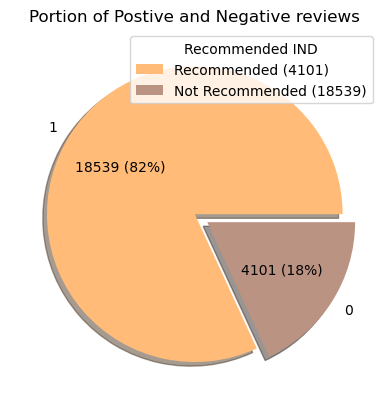

In [12]:
# Plot dependent variable distribution
# parameters for plot
sizes = df['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#FFBB77', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()

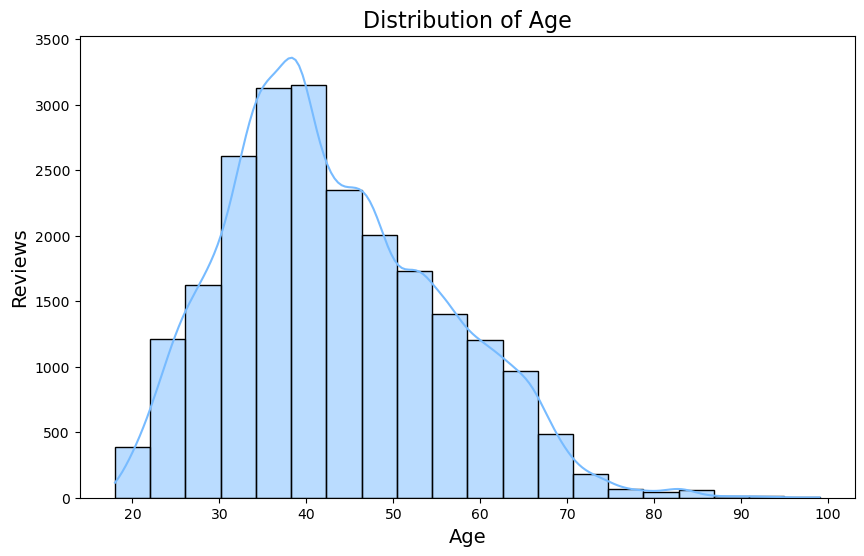

In [13]:
# Plot Age Distribution

# Histogram for Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='#77BBFF')

# Adding title and labels
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Reviews', fontsize=14)

# Show the plot
plt.show()


C:\Users\Alvis\AppData\Local\Temp\ipykernel_5776\646103060.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='Blues')


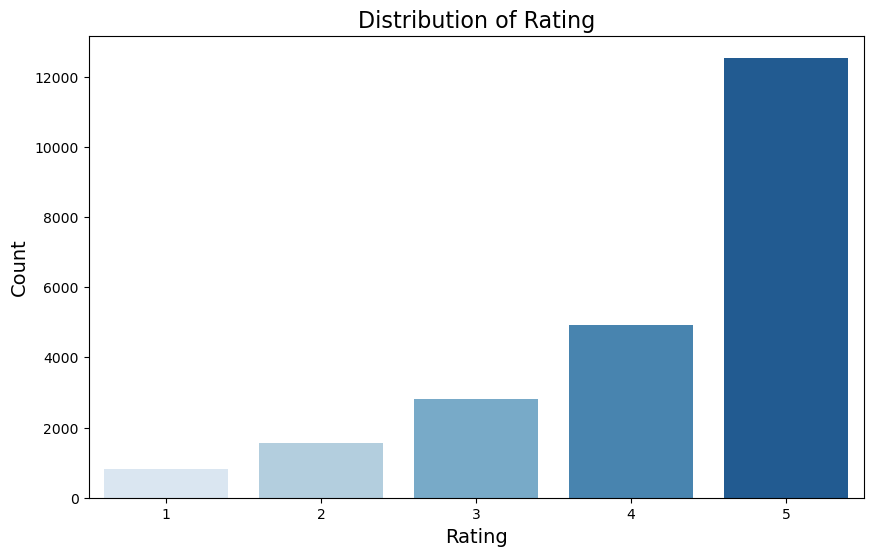

In [14]:
# Plot Rating Distribution

plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='Blues')
plt.title('Distribution of Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()



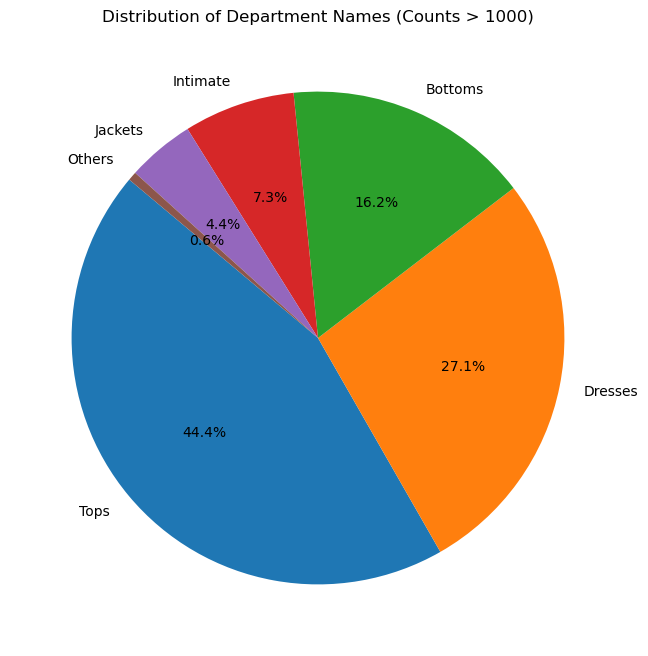

In [15]:
threshold = 1000
class_counts = df['Department Name'].value_counts()
filtered_counts = class_counts[class_counts > threshold]
others_count = class_counts[class_counts <= threshold].sum()

new_counts = filtered_counts.copy()
new_counts['Others'] = others_count

plt.figure(figsize=(8, 8))
plt.pie(new_counts, labels=new_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Department Names (Counts > 1000)')
plt.show()

In [16]:
# Check total Cloth items in dataset
print("Clothing Item Counts in dataset: ", len(df["Clothing ID"].unique()))

Clothing Item Counts in dataset:  1179


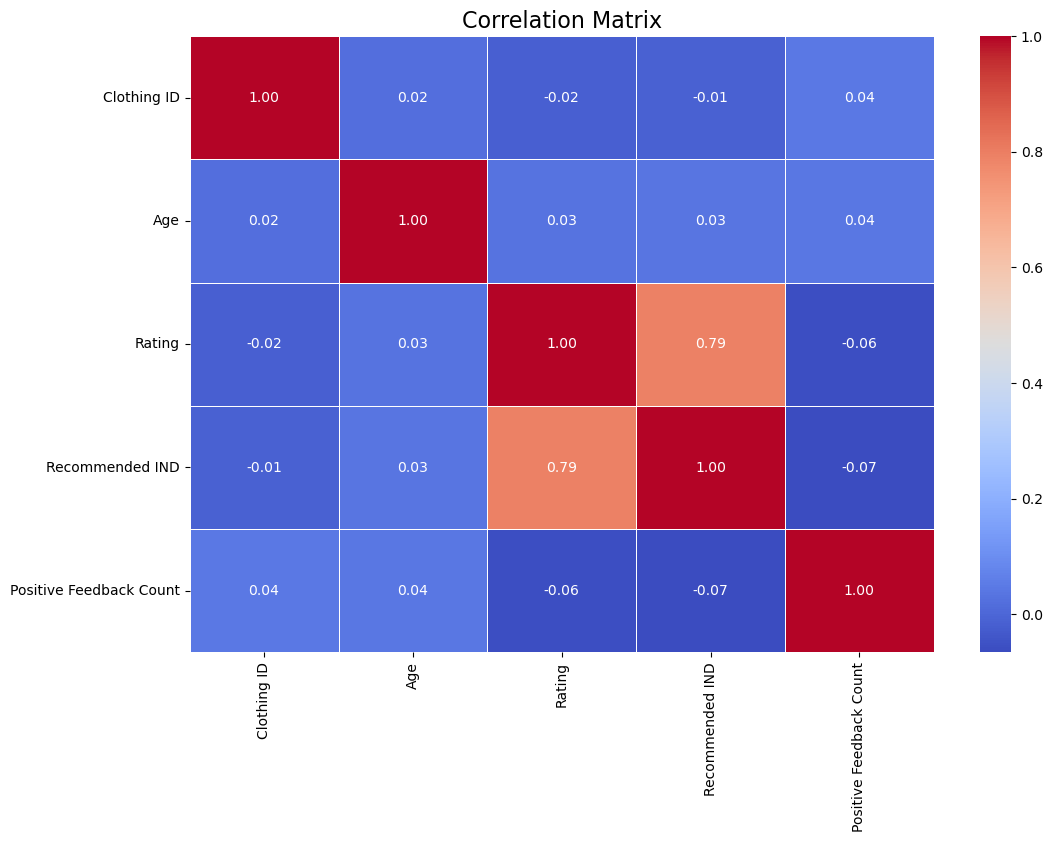

In [17]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Step 3: Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Step 4: Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    fmt=".2f",   # Format to 2 decimal places
    cmap='coolwarm', 
    linewidths=0.5
)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

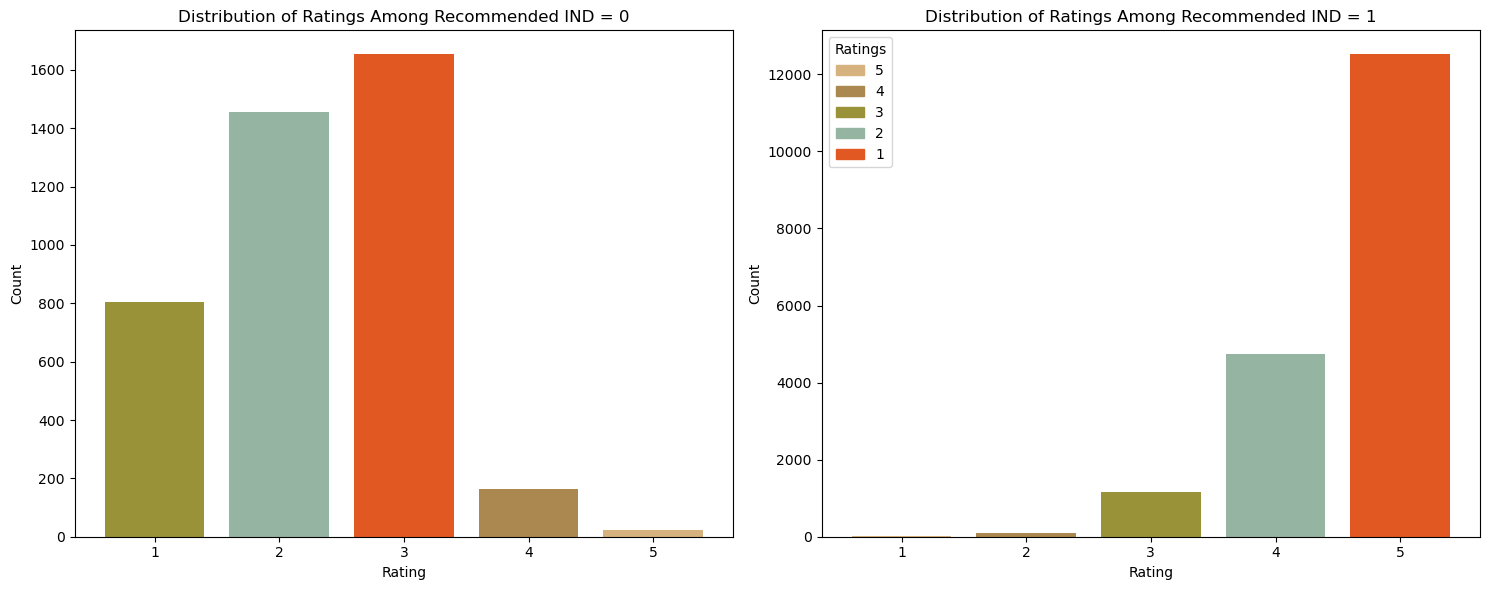

In [18]:
df_recommended_0 = df[df['Recommended IND'] == 0]
df_recommended_1 = df[df['Recommended IND'] == 1]
colors_0=['#9a9238', '#96b4a2', '#e25822', '#aa884f', '#d6b27f']
colors_1=['#d6b27f', '#aa884f', '#9a9238', '#96b4a2', '#e25822'] #order of 54321

# Create two subplots for the bar charts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart for Recommended IND = 0
sizes_0 = df_recommended_0['Rating'].value_counts().sort_index()
ax[0].bar(sizes_0.index, sizes_0.values, color=colors_0)
ax[0].set_title('Distribution of Ratings Among Recommended IND = 0')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')
ax[0].set_xticks(sizes_0.index)

# Bar chart for Recommended IND = 1
sizes_1 = df_recommended_1['Rating'].value_counts().sort_index()
ax[1].bar(sizes_1.index, sizes_1.values, color=colors_1)
ax[1].set_title('Distribution of Ratings Among Recommended IND = 1')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Count')
ax[1].set_xticks(sizes_1.index)

# Add a legend
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors_1]
labels = sorted(df['Rating'].unique(), reverse=True)
plt.legend(handles, labels, title="Ratings")

plt.tight_layout()
plt.show()

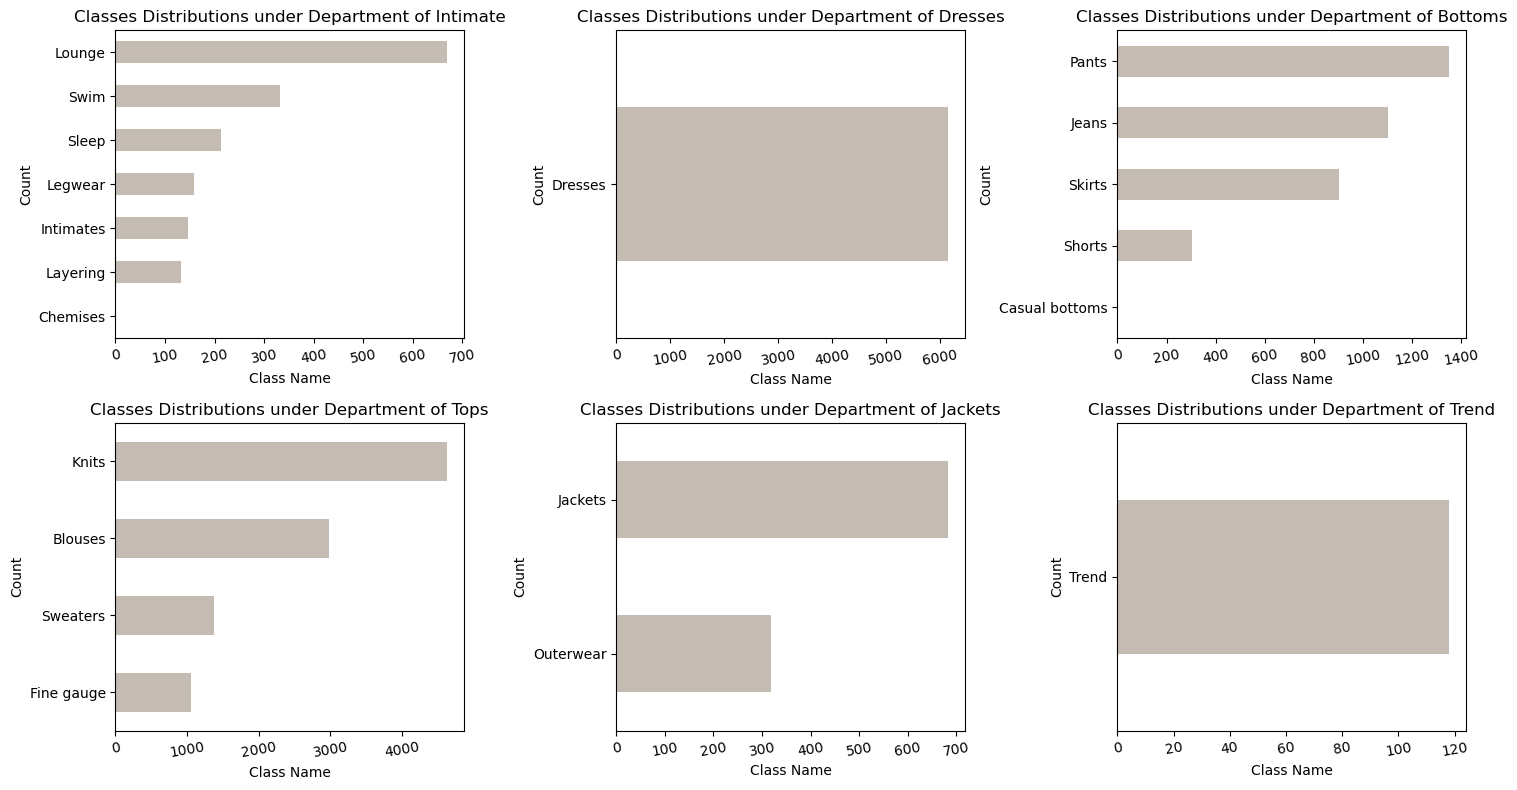

In [19]:
# Get unique department names
departments = df['Department Name'].unique()
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j < len(departments):
            department = departments[i * num_cols + j]
            department_data = df[df['Department Name'] == department]
            counts = department_data['Class Name'].value_counts().sort_values(ascending=True)
            counts.plot(kind='barh', ax=axes[i, j], color='#c4bcb3')

            axes[i, j].set_title(f'Classes Distributions under Department of {department}', fontsize=12)
            axes[i, j].set_xlabel('Class Name', fontsize=10)
            axes[i, j].set_ylabel('Count', fontsize=10)
            axes[i, j].tick_params(axis='x', rotation=10)
        else:
            # Hide empty subplots
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

**EDA(Text)**

In [20]:
# Append 'Title' to 'Review Text'
df['Review Text'] = df.apply(lambda row: row['Review Text']  + ' ' + row['Title'], axis=1)

# Drop the "Title" column if it's no longer needed
df.drop(columns=['Title'], inplace=True)

In [21]:
# Train/Test Split
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"There are {train.shape[0]} rows in training data")
print(f"There are {test.shape[0]} rows in testing data")

There are 18112 rows in training data
There are 4528 rows in testing data


In [22]:
def text_preprocessing(text):
    # convert to lower case
    text = text.str.lower()
    
    # Remove punctuation 
    text = text.apply(lambda doc: re.sub(r'[^\w\s]', '', doc))
    
    # Remove numbers
    text = text.apply(lambda doc: re.sub(r'\d+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda doc: ' '.join([word for word in doc.split() if word not in stop_words]))

    # stemming
    porter_stemmer = PorterStemmer()
    text = text.apply(lambda doc: ' '.join([porter_stemmer.stem(word) for word in word_tokenize(doc)]))
    
    # Lemmatization - have lookup error,Resource 'corpora/wordnet' not found.
#     lemmatizer = WordNetLemmatizer()
#     text = text.apply(lambda doc: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]))

    # remove extra spaces
    text = text.apply(lambda doc: re.sub(' +', ' ', doc))

    return text

In [23]:
# Text preprocessing
train['clean_text'] = text_preprocessing(train['Review Text'])
test['clean_text'] = text_preprocessing(test['Review Text'])

In [30]:

# Filter data based on Recommended IND
recommended_reviews = train[train['Rating'] == 5][train['Recommended IND'] == 1]['clean_text'].dropna()
not_recommended_reviews = train[train['Rating'] == 1][train['Recommended IND'] == 0]['clean_text'].dropna()
#recommended_reviews = df[df['Rating'] == 5][df['Recommended IND'] == 1]['Review Text'].dropna()
#not_recommended_reviews = df[df['Rating'] == 1][df['Recommended IND'] == 0]['Review Text'].dropna()

# Combine cleaned text for each category
text_recommended = " ".join(recommended_reviews)
text_not_recommended = " ".join(not_recommended_reviews)


C:\Users\Alvis\AppData\Local\Temp\ipykernel_5776\3798660911.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommended_reviews = train[train['Rating'] == 5][train['Recommended IND'] == 1]['clean_text'].dropna()
C:\Users\Alvis\AppData\Local\Temp\ipykernel_5776\3798660911.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_recommended_reviews = train[train['Rating'] == 1][train['Recommended IND'] == 0]['clean_text'].dropna()


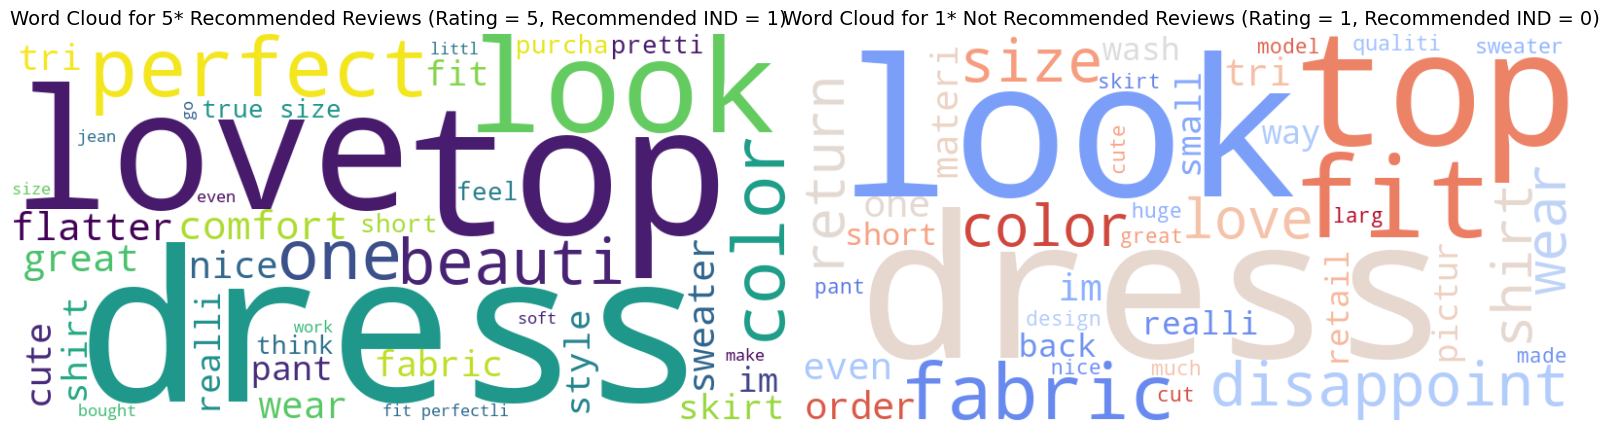

In [31]:
# Generate Word Clouds
wordcloud_recommended = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=40, 
    colormap='viridis'
).generate(text_recommended)

wordcloud_not_recommended = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=40, 
    colormap='coolwarm'
).generate(text_not_recommended)

# Display the Word Clouds
plt.figure(figsize=(16, 6))

# Word Cloud for Recommended IND = 1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_recommended, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 5* Recommended Reviews (Rating = 5, Recommended IND = 1)", fontsize=14)

# Word Cloud for Recommended IND = 0
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_not_recommended, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 1* Not Recommended Reviews (Rating = 1, Recommended IND = 0)", fontsize=14)

plt.tight_layout()
plt.show()

In [32]:
# Step 1: Load GloVe embeddings into a dictionary
def load_glove(file_path):
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

# Path to your downloaded GloVe file (e.g., "glove.6B.100d.txt")
glove_file_path = "./glove.twitter.27B/glove.twitter.27B.100d.txt"
glove_embeddings = load_glove(glove_file_path)
print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")

Loaded 1193514 word vectors from GloVe.


In [28]:
def document_vector(words, embeddings, vector_size=100):

    valid_words = [embeddings[word] for word in words if word in embeddings]

    if len(valid_words) > 0:

        return np.mean(valid_words, axis=0)

    else:

        return np.zeros(vector_size) # Return zero vector if no valid words

In [33]:
def text_preprocessing_glove(text):
    
    # Lemmatization - have lookup error,Resource 'corpora/wordnet' not found.
#     lemmatizer = WordNetLemmatizer()
#     text = text.apply(lambda doc: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]))

    # remove extra spaces
    text = text.apply(lambda doc: re.sub(' +', ' ', doc))

    return text

In [ ]:
# Go back and use un-preprocessed text for Glove embedding
train['clean_text'] =text_preprocessing_glove(train['Review Text'])
test['clean_text'] = text_preprocessing_glove(test['Review Text'])

# Tokenizer using Tensorflow Keras
VOCAB_SIZE = unique_words_train # unique words in training set
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)